# Grad-CAM (Gradient-weighted Class Activation Mapping)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


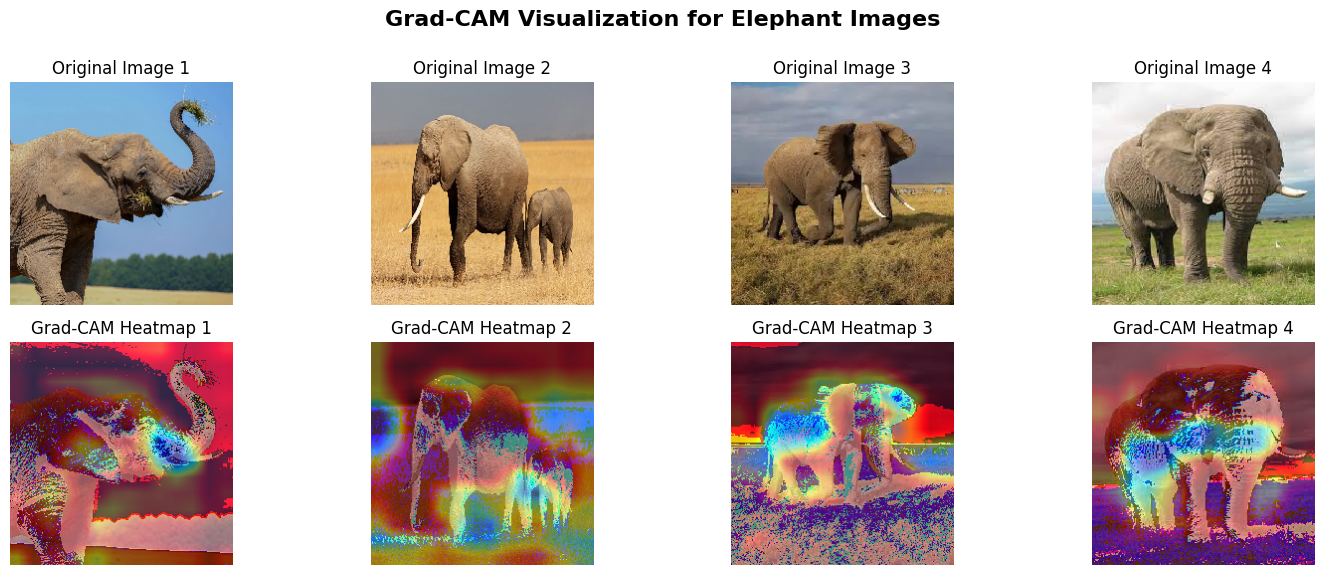

In [61]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2

# Load pre-trained model
model = VGG16(weights="imagenet")

# Function to compute Grad-CAM heatmap
def compute_grad_cam(image_input, predicted_class):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer("block5_conv3").output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_input)
        loss = predictions[:, predicted_class]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_sum(pooled_grads * conv_outputs[0], axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)  # Normalize heatmap
    return heatmap

# List of image paths
image_paths = ["elephant1.jpg", "elephant2.jpg", "elephant3.jpg", "elephant4.jpg"]  # Replace with actual paths

# Prepare data for visualization
original_images = []  # To store original images
heatmaps = []  # To store heatmaps

for image_path in image_paths:
    # Load and preprocess the image
    try:
        image = load_img(image_path, target_size=(224, 224))
    except FileNotFoundError:
        print(f"Image file not found: {image_path}")
        continue

    # Convert to array and keep a copy for the original display
    image_array = img_to_array(image)
    original_images.append(image_array.astype("uint8"))  # Store original unprocessed image

    # Preprocess the image for the model
    image_input = preprocess_input(np.expand_dims(image_array, axis=0))

    # Forward pass and compute Grad-CAM heatmap
    predictions = model.predict(image_input)
    predicted_class = np.argmax(predictions[0])
    heatmap = compute_grad_cam(image_input, predicted_class)

    # Resize heatmap to match original image size
    heatmap_resized = cv2.resize(heatmap, (image_array.shape[1], image_array.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Overlay heatmap on the original image
    overlay = cv2.addWeighted(image_array.astype("uint8"), 0.6, heatmap_color, 0.4, 0)
    heatmaps.append(overlay)

# Plot original images and heatmaps
num_images = len(original_images)
fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

# Add a main title for the entire figure
fig.suptitle("Grad-CAM Visualization for Elephant Images", fontsize=16, weight="bold", y=0.95)

for i in range(num_images):
    # Plot original image in the first row
    axes[0, i].imshow(original_images[i] / 255.0)  # Normalize for display
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Original Image {i + 1}", fontsize=12)

    # Plot heatmap in the second row
    axes[1, i].imshow(heatmaps[i] / 255.0)  # Normalize for display
    axes[1, i].axis("off")
    axes[1, i].set_title(f"Grad-CAM Heatmap {i + 1}", fontsize=12)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



## Code explanation:
This Python script demonstrates the Grad-CAM (Gradient-weighted Class Activation Mapping) technique to visualize the regions of images that contribute most to a convolutional neural network’s (CNN) predictions.

The script uses the VGG16 model from the tensorflow.keras.applications module, which is pre-trained on the ImageNet dataset. This model is used to perform image classification and is the backbone for generating Grad-CAM heatmaps. Using tf.GradientTape, the gradients of the class score (predicted for the input image) with respect to the feature map of the last convolutional layer (block5_conv3) are computed. The gradients are pooled spatially (averaged over width and height) to obtain a single importance weight for each filter.

The feature maps are weighted by these pooled gradients and summed along the channel dimension to form the Grad-CAM heatmap. The heatmap is normalized to have values between 0 and 1 for better visualization.

The script preprocesses the images to ensure compatibility with the VGG16 model. Images are resized to the required input size (224x224 pixels). Pixel values are normalized using preprocess_input, which adjusts them to the range expected by the model.

For each image, Grad-CAM heatmaps are generated. The heatmap is resized to match the original image’s resolution using OpenCV. A color map (COLORMAP_JET) is applied to the heatmap, and it is overlaid on the original image for visualization. Using matplotlib, the original images and their corresponding Grad-CAM heatmaps are displayed in a grid format. The titles and layouts are adjusted for clarity.

## Output explanation:
The output consists of two rows of images, top row displays the original images of elephants. These images serve as input to the model for classification and the bottom row shows the Grad-CAM heatmaps overlaid on the original images. These visualizations highlight the regions of the image that the CNN focused on to make its prediction. For example:

The heatmap-1 is concentrated around the elephant’s trunk, which is a distinctive feature for classification. In heatmap-2, both the mother elephant and the baby are highlighted, indicating that the model considers these regions important for identifying the subject. Heatmap-3 focuses on the elephants’ heads and trunks, key features for distinguishing them from other animals. In heatmap-4 , it emphasizes the entire body of the elephant, which is consistent with the model recognizing its shape and texture.

 # SHAP (Shapley Additive Explanations)

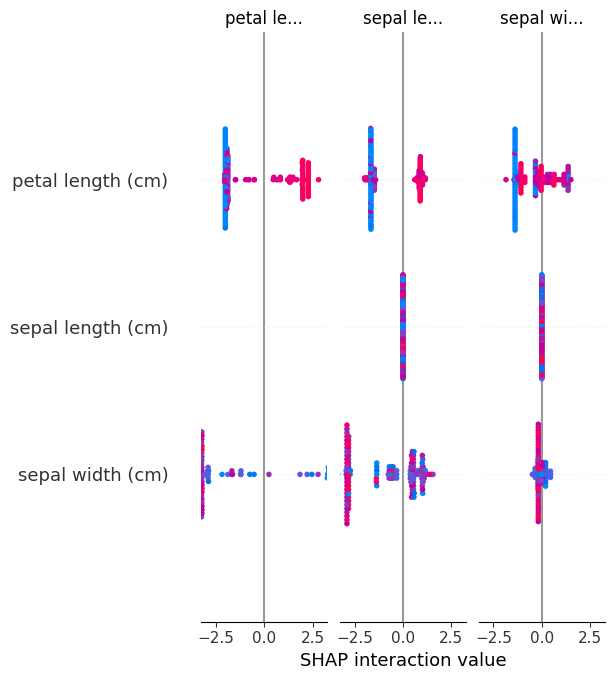

In [62]:
import shap
import xgboost as xgb
from sklearn.datasets import load_iris
import pandas as pd

# Load dataset and train model
data = load_iris()
X, y = data.data, data.target
feature_names = data.feature_names  # Extract feature names
X_df = pd.DataFrame(X, columns=feature_names)  # Convert to pandas DataFrame

# Train the model
model = xgb.XGBClassifier()
model.fit(X, y)

# Create SHAP explainer for tree-based models
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_df)
# Visualize explanations (use only shap_values for one class)
if isinstance(shap_values, list):
    # For multiclass models, take the first class for demonstration
    shap.summary_plot(shap_values[0], X_df)
else:
    # For binary or regression models
    shap.summary_plot(shap_values, X_df)


## Code explanation:
This Python script uses SHAP (Shapley Additive Explanations) to analyze and visualize feature importance for a machine learning model trained on the Iris dataset.

SHAP’s TreeExplainer is used to explain the output of tree-based models like XGBoost. The SHAP explainer computes Shapley values for each feature, quantifying its contribution to the model’s predictions. If the model is multiclass (like this one, with three flower species), SHAP computes separate Shapley values for each class. The script demonstrates this by visualizing the SHAP values for the first class as an example.

## Output explanation:
The generated plot is a SHAP summary plot that visualizes the feature importance and interaction values for the Iris dataset. Features are sorted vertically by their overall importance to the predictions. For example, petal length (cm) appears at the top, indicating it is the most influential feature in this model.

The horizontal spread of points for each feature reflects its contribution (positive or negative) to the predictions. Wider spreads indicate features that have a significant impact on predictions.

Red points represent higher feature values, while blue points represent lower feature values. For instance, a higher petal length (cm) contributes positively to the prediction, while a lower value might contribute negatively. Features like sepal width (cm) have narrower spreads, indicating lower overall impact. This suggests that some features are more relevant for distinguishing between classes than others. For multiclass classification problems, this plot focuses on one class at a time, enabling domain experts to interpret the impact of features for specific outcomes.

This plot helps data scientists to identify the most critical features for model predictions and helps to understand how feature values influence the classification decisions also debug the model by checking if the important features align with domain knowledge.

 # LIME (Local Interpretable Model-agnostic Explanations)

In [63]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

# Load dataset and train model
data = load_iris()
X, y = data.data, data.target
model = RandomForestClassifier()
model.fit(X, y)

# Create LIME explainer
explainer = LimeTabularExplainer(X, feature_names=data.feature_names, class_names=data.target_names, discretize_continuous=True)

# Explain a prediction
sample_instance = X[0].reshape(1, -1)
explanation = explainer.explain_instance(sample_instance.flatten(), model.predict_proba)

# Print explanation
explanation.show_in_notebook()


## Code explanation:
This Python script uses LIME (Local Interpretable Model-agnostic Explanations) to interpret a prediction made by a Random Forest classifier on the Iris dataset. The LimeTabularExplainer is instantiated to explain the predictions of the trained model.

A single instance (X[0]) from the dataset is selected for explanation. The explain_instance method generates a human-readable explanation of the prediction for this specific data point. The method outputs, Feature contributions (how each feature influenced the model’s prediction) and Class probabilities (the probability distribution of the predicted class.)

## Output explanation:
The LIME output explains why the model predicted the sample instance as setosa with a probability of 1.0. Here's how to interpret the visualization:

The bar chart on the left shows the predicted probabilities for each class: setosa 1.00 (100% confident), versicolor 0.00 and virginica 0.00. This indicates that the model is certain the sample belongs to the setosa class.

On the right, the chart lists features contributing to the decision, divided into: “NOT versicolor” (green), features pushing the prediction away from versicolor. “versicolor” (orange), features pulling the prediction toward versicolor. For example:petal width (cm) <= 0.30 contributes significantly to "NOT versicolor," supporting the setosa classification.petal length (cm) <= 1.60 also supports "NOT versicolor," reinforcing the prediction.